In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

import xgboost as xgb

from scipy import sparse
from IPython.display import Image
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

sns.set(style="ticks", color_codes=True)
%matplotlib inline

import os
import json

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from datetime import datetime
import dateutil

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
Path = "profiles/"
filelist = os.listdir(Path)

In [3]:
def read_all():
    
    flag=0
    flag2=0
    
    user_keys = ['alias', 'username', 'numberPosts', 'descriptionProfile', 'numberFollowers', 'numberFollowing', 'urlProfile', 'urlImgProfile', 'website'] # The keys you want
    post_keys = ['url', 'urlImage', 'numberLikes', 'localization', 'date', 'description', 'tags', 'multipleImage', 'mentions', 'isVideo', 'filename'] # The keys you want
    
    #user_cols=['urlProfile', 'numberPosts', 'alias', 'descriptionProfile',  'numberFollowers', 'urlImgProfile', 'username', 'website', 'numberFollowing']
    user_cols=['urlProfile', 'alias', 'numberFollowing', 'numberFollowers', 'username', 'numberPosts', 'website', 'descriptionProfile',  'urlImgProfile']
    # might switch multipleImage and isVideo
    post_cols = ['url', 'description',  'date', 'numberLikes', 'tags', 'filename', 'urlImage', 'localization', 'isVideo', 'multipleImage', 'mentions']
    
    for k in filelist:
        if k.endswith(".json"):  # You could also add "and i.startswith('f')
            
            # Read file
            with open(Path + str(k)) as json_data:
                        data = json.load(json_data)
                            
            if (data['posts']!=[]):
                
                if data["descriptionProfile"]!=None:
                    temp=data["descriptionProfile"]
                    data["descriptionProfile"]=temp[0]
                           
                # Generate user data
                user_data=dict((k, data[k]) for k in user_keys if k in data)
                user_df=pd.DataFrame.from_dict(user_data, orient='index').T

                # Generate posts data for given user
                for i in range(0,len(data['posts'])):
                    
                    for k in post_keys:
                        if k in data['posts'][i]:
                            if isinstance(data['posts'][i][k], str):
                                data['posts'][i][k]=data['posts'][i][k].replace('\r','')

                    post=dict((k, data['posts'][i][k]) for k in post_keys if k in data['posts'][i])

                    if (flag==0):
                        all_posts=np.hstack((user_df, pd.DataFrame.from_dict(post, orient='index').T))
                        flag=1
                    else:
                        new_post=np.hstack((user_df, pd.DataFrame.from_dict(post, orient='index').T))
                        all_posts=np.vstack((all_posts,new_post)) 


                if (flag2==0):
                    total=pd.DataFrame(all_posts, columns=list(reversed(user_keys))+list(reversed(post_keys)))
                    flag2=1
                else:
                    total=np.vstack((total,pd.DataFrame(all_posts, columns=list(reversed(user_keys))+list(reversed(post_keys)))))   
           
                flag=0

    dataset=pd.DataFrame(total, columns=user_cols+post_cols)
    return dataset[["alias", "username", "numberFollowers", "numberFollowing", "numberPosts", 'urlProfile', 'urlImgProfile', 'descriptionProfile', 'website', 'filename', 'url', 'urlImage', 'numberLikes', 'description', 'tags', 'mentions', 'localization', 'date', 'multipleImage', 'isVideo']]

In [ ]:
dataset = read_all()
dataset.to_csv('newDataset.csv', index=False)

# Import Dataset

In [129]:
full=pd.read_csv('dataset.csv', sep=',', na_values='NaN')
y=full["numberLikes"]

toDrop = ['username', 'urlProfile', 'urlImgProfile', 'filename', 'url', 'urlImage', 'isVideo']
processed = full.drop(toDrop,axis=1)

nonCat = ['descriptionProfile', 'description', 'tags', 'mentions', 'localization']
processed = processed.drop(nonCat, axis=1)

# Select data

In [130]:
pd.options.display.float_format = '{:.2f}'.format
processed.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes
count,16539.00,16539.00,16539.00,16539.00
mean,2315.73,2590.56,997829.41,24414.26
std,2655.38,59090.66,1934400.77,64220.60
min,15.00,0.00,124965.00,0.00
25%,787.00,191.00,198039.00,3232.50
50%,1481.00,396.00,393843.00,7351.00
75%,2932.00,645.00,935310.00,18357.00
max,27671.00,1838511.00,22130730.00,1115123.00


(array([  1.54160000e+04,   6.13000000e+02,   2.34000000e+02,
          9.10000000e+01,   6.60000000e+01,   4.00000000e+01,
          2.30000000e+01,   1.50000000e+01,   5.00000000e+00,
          1.10000000e+01,   8.00000000e+00,   5.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   3.00000000e+00]),
 array([       0.        ,    74341.53333333,   148683.06666667,
          223024.6       ,   297366.13333333,   371707.66666667,
          446049.2       ,   520390.73333333,   594732.26666667,
          669073.8       ,   743415.33333333,   817756.86666667,
          892098.4       ,   966439.93333333,  1040781.46666667,  1115123.        ]),
 <a list of 15 Patch objects>)

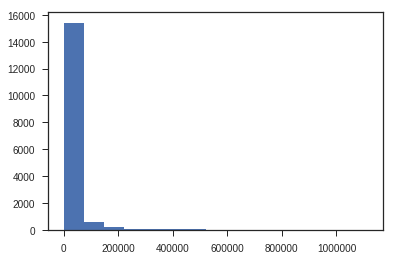

In [131]:
plt.hist(processed.numberLikes, 15)
#plt.xlim(80000, 800000)
#plt.ylim(0, 2000)

In [132]:
le = preprocessing.LabelEncoder()
le.fit(processed["alias"])
list(le.classes_)
alias_num=le.transform(processed["alias"])
#list(le.inverse_transform(alias_num))
processed["aliasNum"]=alias_num

In [133]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"],axis=0)):
    numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(processed[processed["aliasNum"]==i]["numberLikes"])/len(processed[processed["aliasNum"]==i]))
    if (avgLikes[i]<200000 and processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0]<10000000):
        selection=np.append(selection, i)

In [134]:
pd.DataFrame(selection).describe()

,0
count,950.00
mean,484.78
std,280.25
min,0.00
25%,242.25
50%,484.50
75%,726.75
max,971.00


In [135]:
po=pd.DataFrame(avgLikes/numFollowers)
po.describe()

,0
count,972.00
mean,0.02
std,0.02
min,0.00
25%,0.01
50%,0.02
75%,0.03
max,0.17


In [136]:
filtered=processed[processed['aliasNum'].isin(selection)]
filtered.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes,aliasNum
count,16148.00,16148.00,16148.00,16148.00,16148.00
mean,2318.17,2646.36,796490.06,17190.43,484.72
std,2656.96,59800.71,1182281.15,29268.59,280.08
min,15.00,0.00,124965.00,0.00,0.00
25%,800.00,192.00,196489.00,3171.00,242.00
50%,1495.00,397.00,375671.00,7120.50,484.00
75%,2932.00,651.00,882392.00,16994.75,727.00
max,27671.00,1838511.00,9296371.00,364016.00,971.00


(0, 120000)

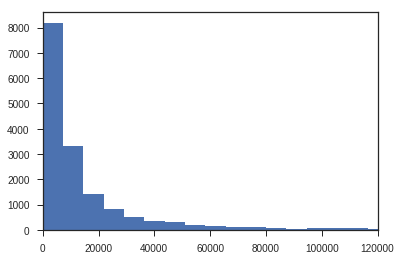

In [137]:
plt.hist(filtered.numberLikes, 50)
plt.xlim(0, 120000)
#plt.ylim(0, 2000)

(0, 1000000)

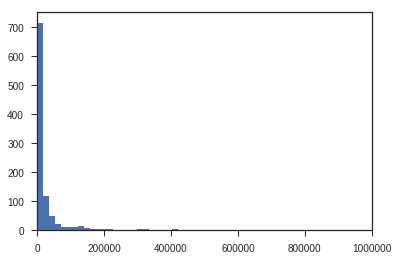

In [138]:
plt.hist(avgLikes,50)
plt.xlim(0, 1000000)
#plt.ylim(0, 2000)

In [139]:
pd.DataFrame(avgLikes).describe()

,0
count,972.00
mean,24429.64
std,61732.63
min,110.87
25%,3594.37
50%,7689.24
75%,18719.16
max,875806.41


# Feature extraction

In [140]:
modified = filtered.drop(["alias"],axis=1)
modified = modified.reset_index(drop=True)

### Convert website to categorical features

In [141]:
modified['youtube']=modified['website'].str.contains("youtube|youtu", na=False).astype(int)
modified['music']=modified['website'].str.contains("soundcloud|spoti", na=False).astype(int)
modified['tumblr']=modified['website'].str.contains("tumblr", na=False).astype(int)
modified['facebook']=modified['website'].str.contains("facebook", na=False).astype(int)
modified['blog']=modified['website'].str.contains("blog|wordpress", na=False).astype(int)
modified['twitter']=modified['website'].str.contains("twitter", na=False).astype(int)
modified['other']=modified['website'].str.contains(".", na=False).astype(int)

modified = modified.drop(['website'], axis=1)

### Convert multipleImage to int

In [142]:
modified['multipleImage']=modified['multipleImage'].astype(int)

### Convert dates to days of week

In [143]:
copy=modified["date"].copy()
for i in range(0, len(modified)):
    copy[i] = datetime.weekday((dateutil.parser.parse(modified["date"][i])))
modified["date"]=copy.astype(np.int64)

modified['mon']=(modified['date']==0).astype(int)
modified['tue']=(modified['date']==1).astype(int)
modified['wed']=(modified['date']==2).astype(int)
modified['thu']=(modified['date']==3).astype(int)
modified['fri']=(modified['date']==4).astype(int)
modified['sat']=(modified['date']==5).astype(int)
modified['sun']=(modified['date']==6).astype(int)

modified = modified.drop(['date'], axis=1)

### One hot encode alias number

In [144]:
# One hot encoding
encoder = OneHotEncoder()
encoder.fit(modified["aliasNum"].values.reshape(-1, 1))
alias_sparse = encoder.transform(modified["aliasNum"].values.reshape(-1, 1))

In [145]:
y = modified['numberLikes']
modified = modified.drop(['numberLikes'],axis=1)

In [146]:
modified=sp.sparse.hstack((modified.astype(float), alias_sparse))

In [125]:
modified

<16148x969 sparse matrix of type '<class 'numpy.float64'>'
	with 114918 stored elements in COOrdinate format>

In [126]:
modified.describe()

AttributeError: describe not found

In [127]:
plt.scatter(modified["numberFollowers"], modified["numberLikes"])

TypeError: 'coo_matrix' object is not subscriptable

# Create train and test dataset

In [128]:
y = modified['numberLikes']
modified = modified.drop(['numberLikes'],axis=1)

TypeError: 'coo_matrix' object is not subscriptable

In [147]:
X_train, X_test, y_train, y_test = train_test_split(modified, y, test_size=0.2, random_state=0)

In [148]:
model_xgb = xgb.XGBRegressor(max_depth=3, learning_rate=0.48, n_estimators=361)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(RMSE)

11862.2138362


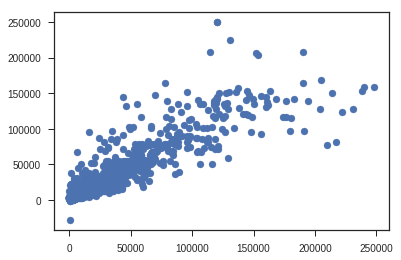

In [149]:
plt.scatter(y_test, y_pred)

In [150]:
def score(params):
    global best2
    global count
    count=count+1
    print(count)
    num_round = int(params['n_estimators'])
    del(params['n_estimators'])
    #params['n_estimators']=num_round
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = mean_squared_error(y_test, predictions)**0.5
    
    if (score<best2):
        best2=score
        print(params)
        print(num_round)
        print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [151]:
def optimize():
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
             'max_depth' : hp.choice('max_depth', np.arange(3, 7, dtype=int)),
             #'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
            #'subsample' : hp.quniform('subsample', 0.6, 0.9, 0.05),
            # 'gamma' : hp.quniform('gamma', 0.6, 0.8, 0.05),
            #'colsample_bytree' : hp.quniform('colsample_bytree', 0.7, 1, 0.05),
              #'reg_alpha' : hp.quniform('reg_alpha', 0.001, 10, 0.01),
             #'reg_lambda' : hp.quniform('reg_lambda', 0.001, 10, 0.01),
             }

    best = fmin(score, space, algo=tpe.suggest, max_evals=50)

    print(best)

In [152]:
best2=100000
count=0
optimize()

1
{'learning_rate': 0.46, 'max_depth': 5}
598
	Score 12833.28656557748


2
{'learning_rate': 0.34, 'max_depth': 6}
635
	Score 12747.969195454129


3
{'learning_rate': 0.48, 'max_depth': 3}
379
	Score 11859.884372273731


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
{'learning_rate': 0.38, 'max_depth': 3}
641
	Score 11626.438049346347


27
28
29
30
31
{'learning_rate': 0.42, 'max_depth': 3}
625
	Score 11515.451681661745


32


KeyboardInterrupt: 